In [1]:
library(dplyr)
library(tidyr)
library(tidyverse)
library(sf)
library(MatchIt)
library(fixest)
install.packages("cobalt")
library(cobalt)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ readr     2.1.4
✔ ggplot2   3.4.1     ✔ stringr   1.5.0
✔ lubridate 1.9.2     ✔ tibble    3.1.8
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Linking to GEOS 3.8.0, GDAL 3.0.4, PROJ 6.3.1; sf_use_s2() is TRUE

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘chk’


 cobalt (Version 4.5.1, Build Date: 2023-04-27)


Attaching package: ‘cobalt’


The following object is masked from ‘package:

In [2]:
# Define the path to the data
mypath = "/kaggle/input/mf-rbase-1km-mdg/mf_rBase_1km_Madagascar.gpkg"

# Define Column Names of Covariates
colname.travelTime = "accessiblity_min"
colname.clayContent = "clay_._mean_0_20"
colname.elevation = "elevation_m"
colname.tri = "TRI"
colname.fcIni = "fc_._2000"

# Prefix of columns for forest cover
colfc.prefix = "fc"
# Separation between prefix and year
colfc.bind = "_._"
# Prefix of columns for forest loss
colfl.prefix = "treeloss_pct_"

# Year of Funding Start
funding.start = 2007

## 1. Calculate Forest Loss

In [3]:
# Load matching frame
mf = st_read(file.path(mypath)) %>%
  filter(group==0 | group==1) %>%
  drop_na() %>%
  st_drop_geometry()

Reading layer `mf_rBase_1km_Madagascar' from data source 
  `/kaggle/input/mf-rbase-1km-mdg/mf_rBase_1km_Madagascar.gpkg' 
  using driver `GPKG'
Simple feature collection with 591917 features and 29 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: 313074.7 ymin: 7167908 xmax: 1089075 ymax: 8675908
Projected CRS: WGS 84 / UTM zone 38S


In [5]:
# The calculation of tree loss area is performed at dataframe base

# Get the column names of tree cover time series
colnames_tree = names(mf)[startsWith(names(mf), colfc.prefix)]
# Drop the first year
dropFirst = tail(colnames_tree, -1)
# Drop the last year
dropLast = head(colnames_tree, -1)
# Set list of new column names for tree loss time series
colnames_loss = dropFirst %>% str_split(., "_")
# Add new columns: treeloss_tn = treecover_tn - treecover_t(n-1)  
for (i in 1:length(dropFirst)) {
  new_colname <- paste0(colfl.prefix, colnames_loss[[i]][3])
  # Calc absolute value of Year_t - Year_(t-1) 
  mf[[new_colname]] <- abs(mf[[dropFirst[i]]] - mf[[dropLast[i]]])
}

In [6]:
# Add column: average treeloss before funding starts, 
# In ths case, from 2001 to 2006
mf$avgLoss_pre_fund = round(rowMeans(mf[grepl(colfl.prefix, names(mf))][1:6]), 2)
colname.flAvg = "avgLoss_pre_fund"

## 2a. Matching

* Good Balance when,
`Std. Mean Diff` and `eCDF stats` close to **`0`** and `variance ratios` close to **`1`**.

* `Std.Pair Diff` displays the average absolute within-pair difference of each covariate. when they're small, better balance, and estimated effects are more robust to misspecification of the outcome model.

In [7]:
# Make cut-off list ####
lst_cutoffs = c()

# Quantile in 8 parts
lst_cutoffs[[colname.travelTime]] = as.integer(quantile(mf[[colname.travelTime]], probs = seq(0, 1, 0.05), na.rm=TRUE))

#lst_cutoffs[[colname.clayContent]] = as.integer(quantile(mf[[colname.clayContent]], probs = seq(0, 1, 0.05), na.rm=TRUE))
lst_cutoffs[[colname.clayContent]] = as.integer(c(0,10,20,30, 32,34,36,38,40, 50,60,70,80,90,100))

lst_cutoffs[[colname.elevation]] = as.integer(quantile(mf[[colname.elevation]], probs = seq(0, 1, 0.1), na.rm=TRUE))

lst_cutoffs[[colname.tri]] = as.integer(quantile(mf[[colname.tri]], probs = seq(0, 1, 0.1), na.rm=TRUE))

lst_cutoffs[[colname.fcIni]] = as.integer(quantile(mf[[colname.fcIni]], probs = seq(0, 1, 0.025), na.rm=TRUE))

lst_cutoffs[[colname.flAvg]] = as.integer(quantile(mf[[colname.flAvg]], probs = seq(0, 1, 0.005), na.rm=TRUE))


In [8]:
# Create Formula from Variables
# Ref: https://stackoverflow.com/questions/66357664/using-variable-as-function-argument-in-r
formula = eval(bquote(group ~ .(as.name(colname.travelTime)) + .(as.name(colname.clayContent)) +
                        .(as.name(colname.elevation)) + .(as.name(colname.tri)) +
                        .(as.name(colname.fcIni)) + .(as.name(colname.flAvg))
))

# CEM Match
out.cem = matchit(formula,
                  data = mf, 
                  method = "cem", 
                  cutpoints = lst_cutoffs)

In [9]:
# Summary of matching output
summary(out.cem)


Call:
matchit(formula = formula, data = mf, method = "cem", cutpoints = lst_cutoffs)

Summary of Balance for All Data:
                 Means Treated Means Control Std. Mean Diff. Var. Ratio
accessiblity_min      663.5408      500.5487          0.4554     1.3722
clay_._mean_0_20       30.6966       25.9559          1.0156     0.9753
elevation_m           524.1942      544.7599         -0.0575     0.6303
TRI                    44.7896       29.0770          0.5575     1.5729
fc_._2000              93.0923       53.7427          2.0024     0.2977
avgLoss_pre_fund        0.0478        0.0855         -0.1515     0.3896
                 eCDF Mean eCDF Max
accessiblity_min    0.0829   0.1850
clay_._mean_0_20    0.1102   0.4150
elevation_m         0.0352   0.0882
TRI                 0.0859   0.2593
fc_._2000           0.3931   0.5751
avgLoss_pre_fund    0.0039   0.1643

Summary of Balance for Matched Data:
                 Means Treated Means Control Std. Mean Diff. Var. Ratio
accessiblity_m

## 2b. Plot Covariate Balance

`cobalt` library naturally supports the visualization of `MatchIt` outputs,
Reference: https://cloud.r-project.org/web/packages/cobalt/vignettes/cobalt.html#bal.plot

In [10]:
# Define Covariate Labels to show on plots
c_name = data.frame(old = c(colname.travelTime, colname.clayContent, colname.elevation,
                            colname.tri, colname.fcIni, colname.flAvg),
                    new = c("Accessibility", "Clay Content", "Elevation",
                            "TRI", "Forest Cover in 2000", "Avg. Annual Forest \n Loss 2001 ~ 2006"))

In [11]:
# Refer to cobalt::love.plot()
# https://cloud.r-project.org/web/packages/cobalt/vignettes/cobalt.html#love.plot
p_covBal = love.plot(out.cem, 
                     binary = "std", 
                     abs = TRUE,
                     #thresholds = c(m = .1),
                     var.order = "unadjusted",
                     var.names = c_name,
                     sample.names = c("All Samples", "Selected Samples"),
                     wrap = 15) # at how many characters does axis label break to new line

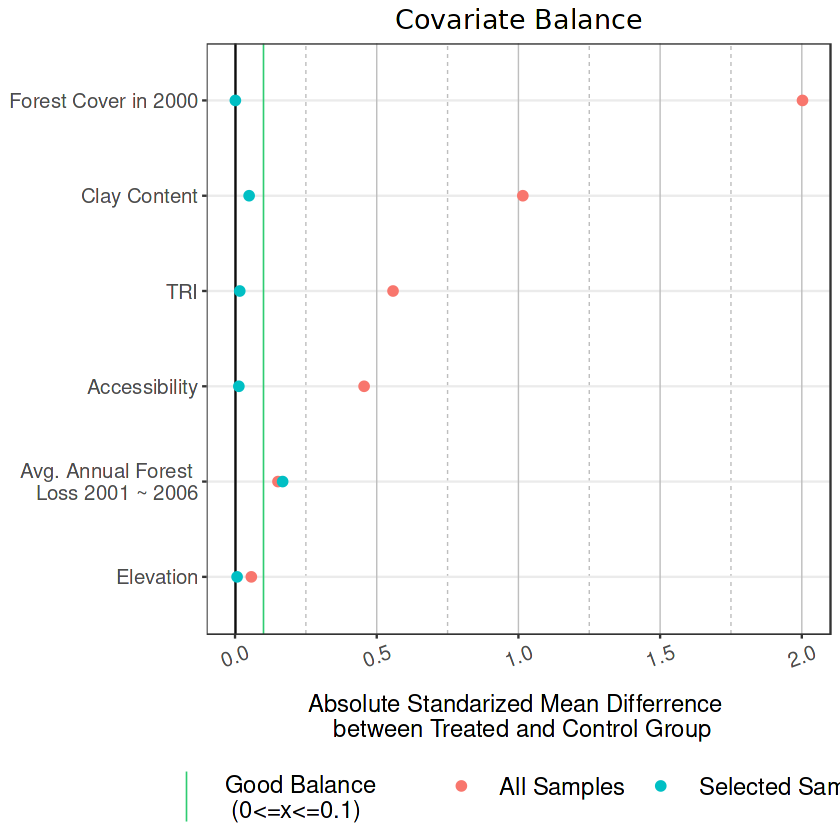

In [12]:
# Finetune Layouts using ggplot
p_covBal + 
  geom_vline(aes(xintercept=0.1, 
                 linetype="Good Balance \n (0<=x<=0.1)"), 
             color=c("#2ecc71"), linewidth=0.35) +
  labs(x = "Absolute Standarized Mean Differrence \n between Treated and Control Group") +
  theme_bw() +
  theme(
    plot.title = element_text(family="Arial Black", size=16, hjust=0.5),
    
    legend.position = "bottom",
    legend.title = element_blank(),
    legend.text=element_text(size=14),
    legend.spacing.x = unit(0.5, 'cm'),
    legend.spacing.y = unit(0.75, 'cm'),
    
    axis.text.x = element_text(angle = 20, hjust = 0.5, vjust = 0.5),
    axis.text=element_text(size=12),
    axis.title=element_text(size=14),
    axis.title.y = element_text(margin = margin(unit = 'cm', r = 0.5)),
    axis.title.x = element_text(margin = margin(unit = 'cm', t = 0.5)),
    
    panel.grid.major.x = element_line(color = 'grey', linewidth = 0.3, linetype = 1),
    panel.grid.minor.x = element_line(color = 'grey', linewidth = 0.3, linetype = 2)
  ) + guides(linetype = guide_legend(override.aes = list(color = "#2ecc71"))) # Add legend for geom_vline

After "matching", the selected treatment and control observations present largely reduced absolute standardized mean differences, implying an improved balance.

## 2c. Density Plots of Matched Objects

In [13]:
# Define Facet Labels
fnl = c(`Unadjusted Sample` = "Before Matching",
        `Adjusted Sample` = "After Matching")

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


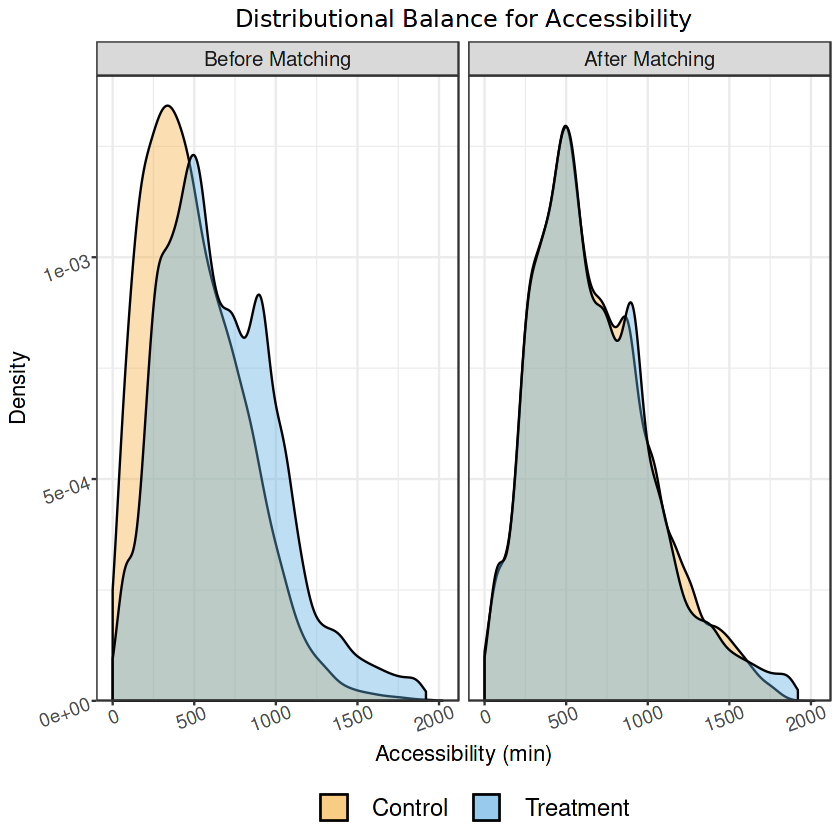

In [14]:
## Density plot for Travel Time
p_travel = bal.plot(out.cem, 
                    var.name = colname.travelTime,
                    #sample.names = c("Control", "Treatment"),
                    which = "both")

# Finetune Layouts using ggplot
p_travel +
  facet_wrap(.~which, labeller = as_labeller(fnl)) +
  #scale_fill_viridis(discrete = T) +
  scale_fill_manual(labels = c("Control", "Treatment"), values = c("#f5b041","#5dade2")) +
  labs(title = "Distributional Balance for Accessibility",
       x = "Accessibility (min)",
       fill = "Group") +
  theme_bw() +
  theme(
    plot.title = element_text(family="Arial Black", size=14, hjust=0.5),
    
    legend.position = "bottom",
    legend.title = element_blank(),
    legend.text=element_text(size=14),
    legend.spacing.x = unit(0.5, 'cm'),
    legend.spacing.y = unit(0.75, 'cm'),
    
    axis.text=element_text(size=11, angle = 20, hjust = 0.7, vjust = 0.7),
    axis.title=element_text(size=13),
    #axis.title.y = element_text(margin = margin(unit = 'cm', r = 0.35)),
    #axis.title.x = element_text(margin = margin(unit = 'cm', t = 0.35)),
    
    strip.text.x = element_text(size = 12) # Facet Label
  )

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


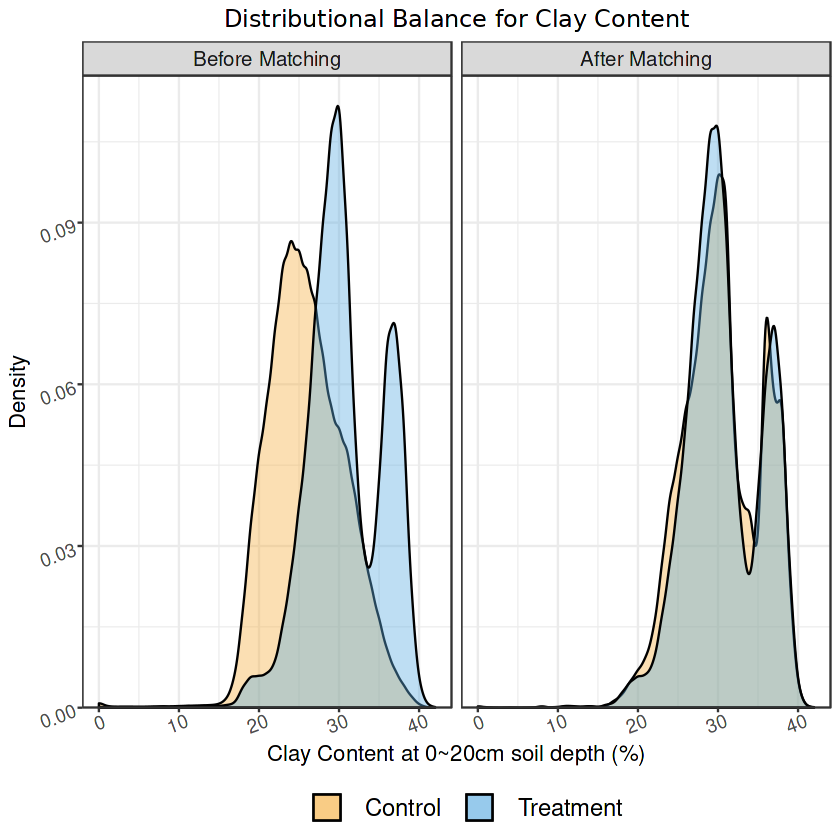

In [15]:
# Density plot for Clay Content
p_clay = bal.plot(out.cem, 
                  var.name = colname.clayContent,
                  which = "both")

p_clay +
  facet_wrap(.~which, labeller = as_labeller(fnl)) +
  #scale_fill_viridis(discrete = T) +
  scale_fill_manual(labels = c("Control", "Treatment"), values = c("#f5b041","#5dade2")) +
  labs(title = "Distributional Balance for Clay Content",
       x = "Clay Content at 0~20cm soil depth (%)",
       fill = "Group") +
  theme_bw() +
  theme(
    plot.title = element_text(family="Arial Black", size=14, hjust=0.5),
    
    legend.position = "bottom",
    legend.title = element_blank(),
    legend.text=element_text(size=14),
    legend.spacing.x = unit(0.5, 'cm'),
    legend.spacing.y = unit(0.75, 'cm'),
    
    axis.text=element_text(size=11, angle = 20, hjust = 0.7, vjust = 0.7),
    axis.title=element_text(size=13),
    #axis.title.y = element_text(margin = margin(unit = 'cm', r = 0.35)),
    #axis.title.x = element_text(margin = margin(unit = 'cm', t = 0.35)),
    
    strip.text.x = element_text(size = 12) # Facet Label
  )

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


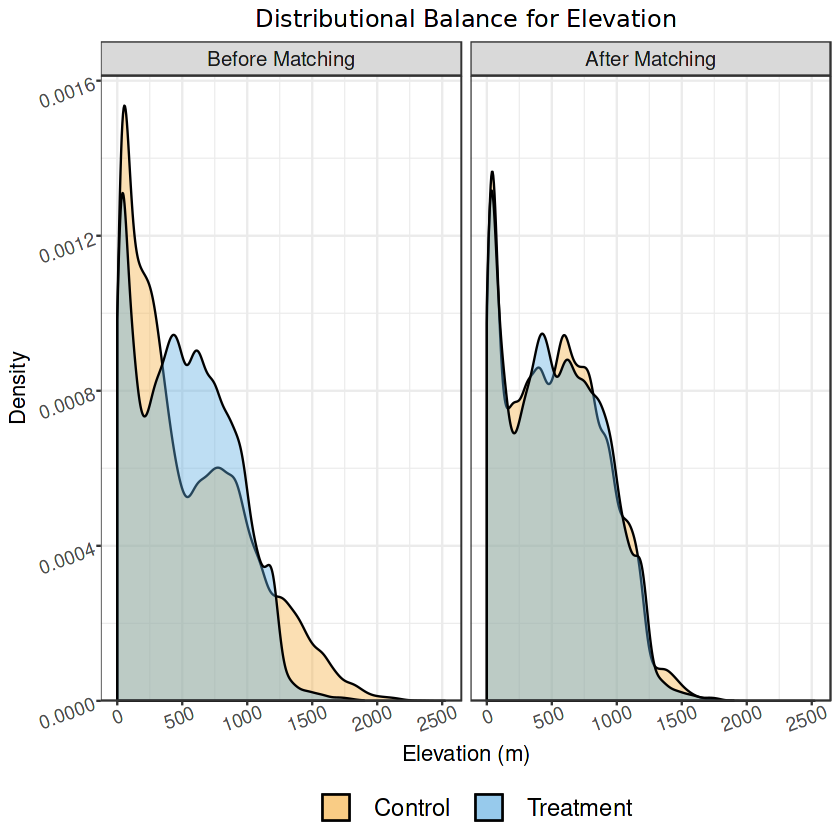

In [16]:
# Density plot for Elevation
p_elevation = bal.plot(out.cem, 
                       var.name = colname.elevation,
                       which = "both")

p_elevation +
  facet_wrap(.~which, labeller = as_labeller(fnl)) +
  #scale_fill_viridis(discrete = T) +
  scale_fill_manual(labels = c("Control", "Treatment"), values = c("#f5b041","#5dade2")) +
  labs(title = "Distributional Balance for Elevation",
       x = "Elevation (m)",
       fill = "Group") +
  theme_bw() +
  theme(
    plot.title = element_text(family="Arial Black", size=14, hjust=0.5),
    
    legend.position = "bottom",
    legend.title = element_blank(),
    legend.text=element_text(size=14),
    legend.spacing.x = unit(0.5, 'cm'),
    legend.spacing.y = unit(0.75, 'cm'),
    
    axis.text=element_text(size=11, angle = 20, hjust = 0.7, vjust = 0.7),
    axis.title=element_text(size=13),
    #axis.title.y = element_text(margin = margin(unit = 'cm', r = 0.35)),
    #axis.title.x = element_text(margin = margin(unit = 'cm', t = 0.35)),
    
    strip.text.x = element_text(size = 12) # Facet Label
  )

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


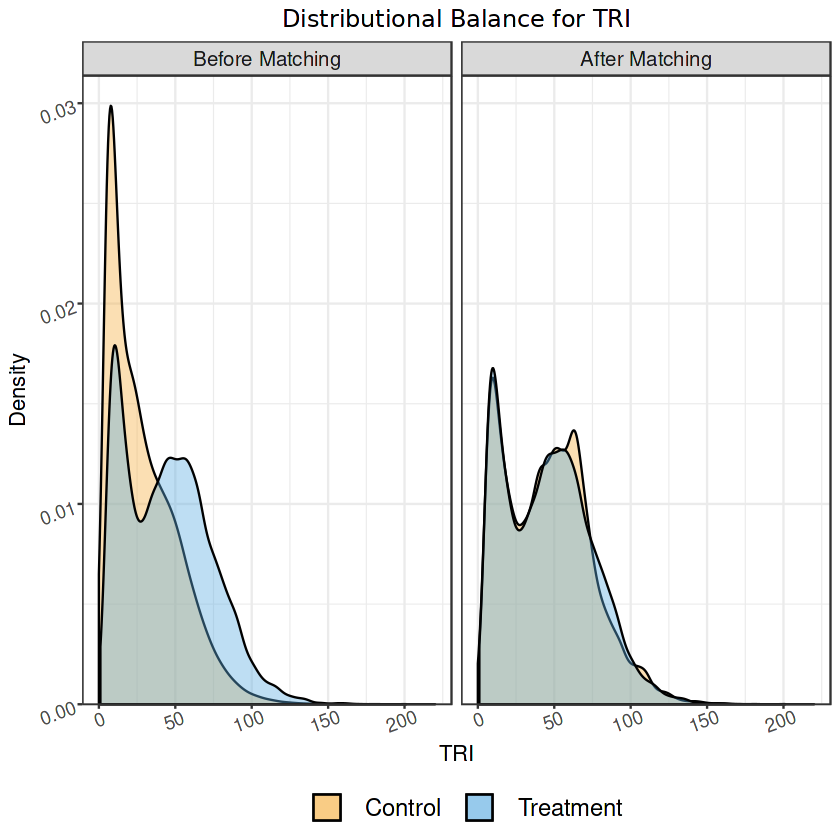

In [17]:
# Density plot for TRI
p_tri = bal.plot(out.cem, 
                 var.name = colname.tri,
                 which = "both")

p_tri +
  facet_wrap(.~which, labeller = as_labeller(fnl)) +
  #scale_fill_viridis(discrete = T) +
  scale_fill_manual(labels = c("Control", "Treatment"), values = c("#f5b041","#5dade2")) +
  labs(title = "Distributional Balance for TRI",
       x = "TRI",
       fill = "Group") +
  theme_bw() +
  theme(
    plot.title = element_text(family="Arial Black", size=14, hjust=0.5),
    
    legend.position = "bottom",
    legend.title = element_blank(),
    legend.text=element_text(size=14),
    legend.spacing.x = unit(0.5, 'cm'),
    legend.spacing.y = unit(0.75, 'cm'),
    
    axis.text=element_text(size=11, angle = 20, hjust = 0.7, vjust = 0.7),
    axis.title=element_text(size=13),
    #axis.title.y = element_text(margin = margin(unit = 'cm', r = 0.35)),
    #axis.title.x = element_text(margin = margin(unit = 'cm', t = 0.35)),
    
    strip.text.x = element_text(size = 12) # Facet Label
  )

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


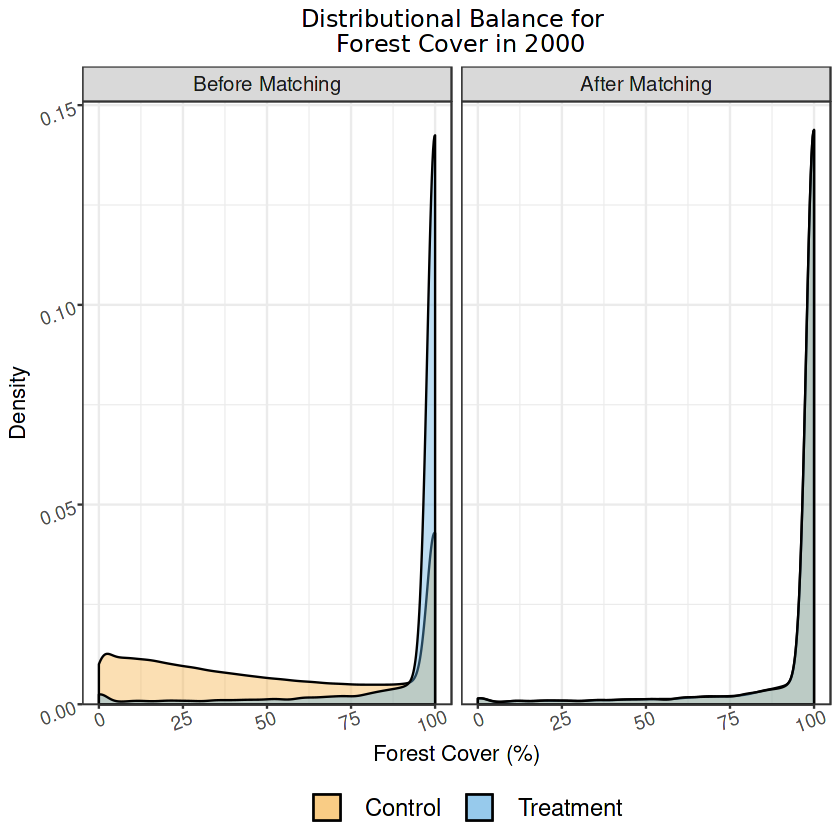

In [18]:
# Density plot for covariate "forest cover 2000"
p_fc = bal.plot(out.cem, 
                var.name = colname.fcIni,
                which = "both")

p_fc +
  facet_wrap(.~which, labeller = as_labeller(fnl)) +
  #scale_fill_viridis(discrete = T) +
  scale_fill_manual(labels = c("Control", "Treatment"), values = c("#f5b041","#5dade2")) +
  labs(title = "Distributional Balance for \n Forest Cover in 2000",
       x = "Forest Cover (%)",
       fill = "Group") +
  theme_bw() +
  theme(
    plot.title = element_text(family="Arial Black", size=14, hjust=0.5),
    
    legend.position = "bottom",
    legend.title = element_blank(),
    legend.text=element_text(size=14),
    legend.spacing.x = unit(0.5, 'cm'),
    legend.spacing.y = unit(0.75, 'cm'),
    
    axis.text=element_text(size=11, angle = 20, hjust = 0.7, vjust = 0.7),
    axis.title=element_text(size=13),
    #axis.title.y = element_text(margin = margin(unit = 'cm', r = 0.35)),
    #axis.title.x = element_text(margin = margin(unit = 'cm', t = 0.35)),
    
    strip.text.x = element_text(size = 12) # Facet Label
  )

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


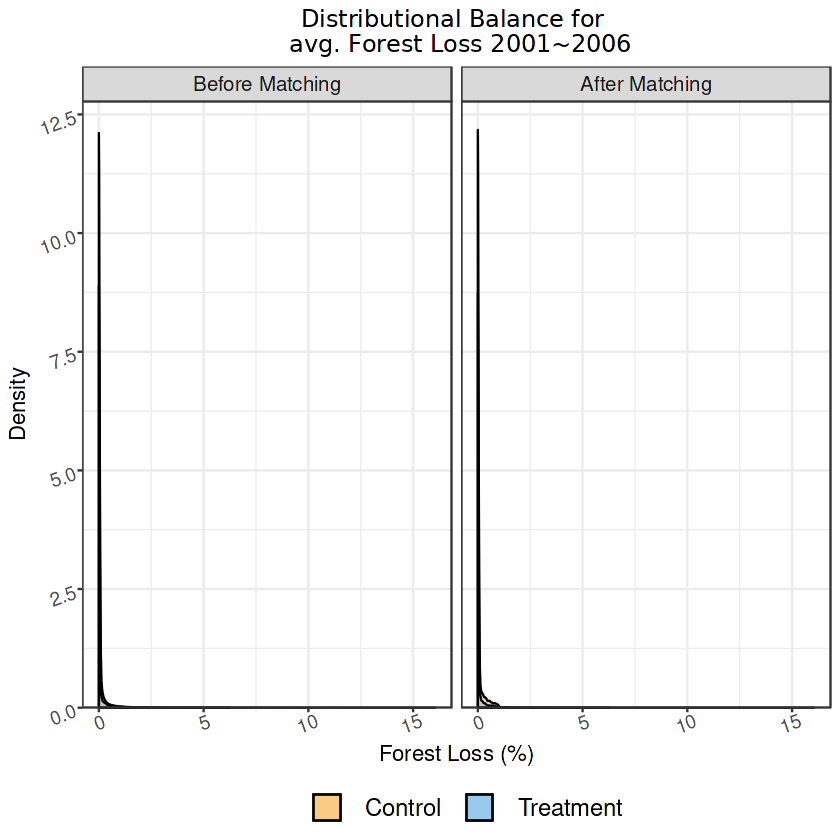

In [19]:
# Density plot for covariate "avg. annual forest loss prior funding"
p_fl = bal.plot(out.cem, 
                var.name = colname.flAvg,
                which = "both")

p_fl +
  facet_wrap(.~which, labeller = as_labeller(fnl)) +
  #scale_fill_viridis(discrete = T) +
  scale_fill_manual(labels = c("Control", "Treatment"), values = c("#f5b041","#5dade2")) +
  labs(title = "Distributional Balance for \n avg. Forest Loss 2001~2006",
       x = "Forest Loss (%)",
       fill = "Group") +
  theme_bw() +
  theme(
    plot.title = element_text(family="Arial Black", size=14, hjust=0.5),
    
    legend.position = "bottom",
    legend.title = element_blank(),
    legend.text=element_text(size=14),
    legend.spacing.x = unit(0.5, 'cm'),
    legend.spacing.y = unit(0.75, 'cm'),
    
    axis.text=element_text(size=11, angle = 20, hjust = 0.7, vjust = 0.7),
    axis.title=element_text(size=13),
    #axis.title.y = element_text(margin = margin(unit = 'cm', r = 0.35)),
    #axis.title.x = element_text(margin = margin(unit = 'cm', t = 0.35)),
    
    strip.text.x = element_text(size = 12) # Facet Label
  )

## 3. Panelize (Un-)Matched Dataframe

In [20]:
# Convert dataframe of matched objects to pivot wide form
matched.wide = match.data(object=out.cem, data=mf)
print(paste0("The total number of matched items: ", as.character(nrow(matched.wide))))

head(matched.wide)

[1] "The total number of matched items: 70952"


,gridID,group,wdpaid,fc_._2000,fc_._2001,fc_._2002,fc_._2003,fc_._2004,fc_._2005,fc_._2006,⋯,treeloss_pct_2015,treeloss_pct_2016,treeloss_pct_2017,treeloss_pct_2018,treeloss_pct_2019,treeloss_pct_2020,treeloss_pct_2021,avgLoss_pre_fund,weights,subclass
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
588,1072,0,0,25.4,25.4,25.4,25.4,25.4,25.4,25.0,⋯,0,0.2,0,0,0,0.1,0.4,0.07,0.2265444,1
591,1075,0,0,0.3,0.3,0.3,0.3,0.3,0.3,0.3,⋯,0,0.0,0,0,0,0.0,0.0,0.00,0.4153313,2
665,1165,0,0,0.8,0.8,0.8,0.8,0.8,0.8,0.8,⋯,0,0.0,0,0,0,0.0,0.0,0.00,0.4153313,2
737,1240,0,0,25.7,25.7,25.7,25.7,25.7,25.7,24.8,⋯,0,0.0,0,0,0,0.0,0.0,0.15,0.2265444,1
823,1329,0,0,33.0,33.0,33.0,33.0,33.0,33.0,33.0,⋯,0,0.0,0,0,0,0.0,0.0,0.00,1.2459939,3
824,1330,0,0,39.4,39.4,39.4,39.4,39.4,39.4,39.4,⋯,0,0.2,0,0,0,0.0,0.0,0.00,4.9839757,4


In [21]:
# Pivot Wide ==> Pivot Long
matched.long = matched.wide %>%
  select(c(group, wdpaid, gridID, weights, starts_with(colfc.prefix))) %>%
  pivot_longer(cols = c(starts_with(colfc.prefix)),
               names_to = c("var", "year"),
               names_sep = colfc.bind,
               values_to = "fc_pct")
head(matched.long)

group,wdpaid,gridID,weights,var,year,fc_pct
<dbl>,<dbl>,<int>,<dbl>,<chr>,<chr>,<dbl>
0,0,1072,0.2265444,fc,2000,25.4
0,0,1072,0.2265444,fc,2001,25.4
0,0,1072,0.2265444,fc,2002,25.4
0,0,1072,0.2265444,fc,2003,25.4
0,0,1072,0.2265444,fc,2004,25.4
0,0,1072,0.2265444,fc,2005,25.4


In [22]:
# Pivot wide Dataframe of un-matched objects
unmatched.wide = mf
print(paste0("The total number of un-matched items: ", as.character(nrow(unmatched.wide))))

head(unmatched.wide)

[1] "The total number of un-matched items: 485690"


,gridID,group,wdpaid,fc_._2000,fc_._2001,fc_._2002,fc_._2003,fc_._2004,fc_._2005,fc_._2006,⋯,treeloss_pct_2013,treeloss_pct_2014,treeloss_pct_2015,treeloss_pct_2016,treeloss_pct_2017,treeloss_pct_2018,treeloss_pct_2019,treeloss_pct_2020,treeloss_pct_2021,avgLoss_pre_fund
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,85,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,⋯,0.0,0,0,0,0,0,0,0,0,0
2,86,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,⋯,0.0,0,0,0,0,0,0,0,0,0
3,87,0,0,0.2,0.2,0.2,0.2,0.2,0.2,0.2,⋯,0.0,0,0,0,0,0,0,0,0,0
4,88,0,0,0.2,0.2,0.2,0.2,0.2,0.2,0.2,⋯,0.0,0,0,0,0,0,0,0,0,0
5,89,0,0,0.4,0.4,0.4,0.4,0.4,0.4,0.4,⋯,0.1,0,0,0,0,0,0,0,0,0
6,90,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,⋯,0.0,0,0,0,0,0,0,0,0,0


In [23]:
# Pivot Wide ==> Pivot Long
unmatched.long = unmatched.wide %>%
  select(c(group, wdpaid, gridID, starts_with(colfc.prefix))) %>%
  pivot_longer(cols = c(starts_with(colfc.prefix)),
               names_to = c("var", "year"),
               names_sep = colfc.bind,
               values_to = "fc_pct")
head(unmatched.long)

group,wdpaid,gridID,var,year,fc_pct
<dbl>,<dbl>,<int>,<chr>,<chr>,<dbl>
0,0,85,fc,2000,0
0,0,85,fc,2001,0
0,0,85,fc,2002,0
0,0,85,fc,2003,0
0,0,85,fc,2004,0
0,0,85,fc,2005,0


In [26]:
# Average treecover 2000 of matched treatment group, identical with CEM summary
#matched.wide %>%
#    filter(group==1) %>% select(c(fc_._2000)) %>%
#    summarise(across(everything(), mean))

# Average treecover 2000 of matched control group, NOT identical with CEM summary!
#matched.wide %>%
#    filter(group==0) %>% select(c(fc_._2000)) %>%
#    summarise(across(everything(), mean))

## 4. Plotting Trend

In [24]:
# Make dataframe for plotting Trend
df.matched.trend = matched.long %>%
  group_by(group, year) %>%
  summarise(avgFC = mean(fc_pct, na.rm=TRUE), n = n(), matched = TRUE)

df.unmatched.trend = unmatched.long %>%
  group_by(group, year) %>%
  summarise(avgFC = mean(fc_pct, na.rm=TRUE), n = n(), matched = FALSE)

df.trend = rbind(df.matched.trend, df.unmatched.trend)
head(df.trend)

`summarise()` has grouped output by 'group'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'group'. You can override using the
`.groups` argument.


group,year,avgFC,n,matched
<dbl>,<chr>,<dbl>,<int>,<lgl>
0,2000,91.80747,59095,TRUE
0,2001,91.78014,59095,TRUE
0,2002,91.73247,59095,TRUE
0,2003,91.67689,59095,TRUE
0,2004,91.58409,59095,TRUE
0,2005,91.47301,59095,TRUE


Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
Warning message:
“Using size for a discrete variable is not advised.”


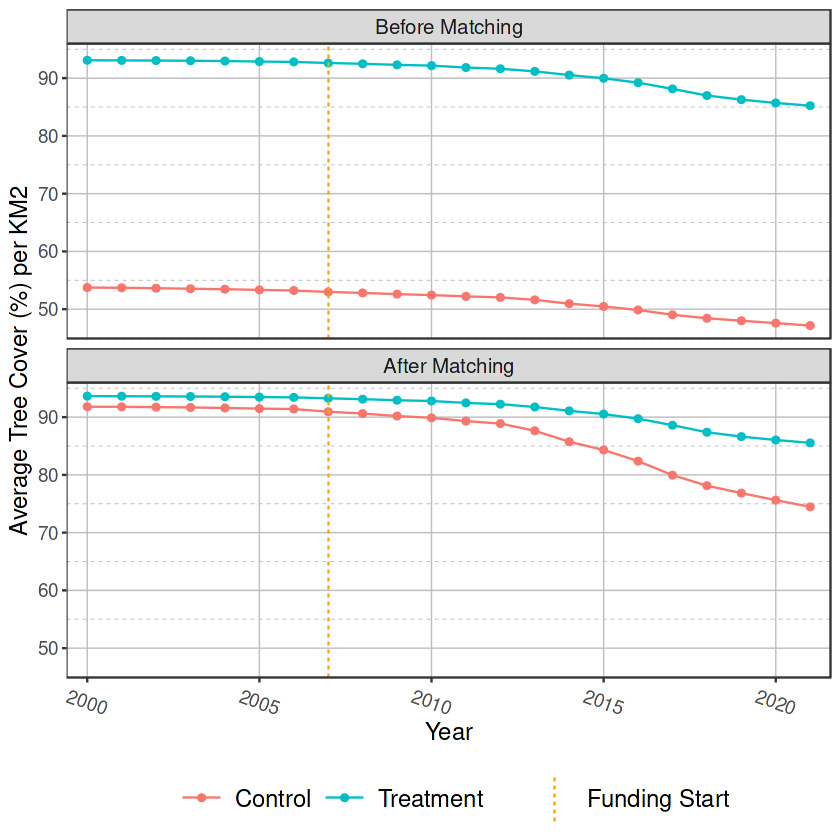

In [25]:
# Change Facet Labels
fct.labs <- c("Before Matching", "After Matching")
names(fct.labs) <- c(FALSE, TRUE)

# Trend Plot
ggplot(df.trend, aes(x = year, y = avgFC)) +
    geom_line(aes(group = group, color = as.character(group))) +
    geom_point(aes(color = as.character(group))) +
    geom_vline(aes(xintercept=as.character(funding.start), size="Funding Start"), linetype=2, linewidth=0.5, color="orange") +
    
    #scale_y_continuous(breaks=seq(0,100,10), labels=paste(seq(0,100,10)),
    #                   expand=c(0,0), limits=c(0,100)) +
    scale_x_discrete(breaks=seq(2000,2020,5), labels=paste(seq(2000,2020,5))) +
    scale_color_hue(labels = c("Control", "Treatment")) +

    facet_wrap(matched~., ncol = 1, #scales = 'free_x',
             labeller = labeller(matched = fct.labs)) +

    labs(x = "Year", y = "Average Tree Cover (%) per KM2", color = "Group") +
    theme_bw() +
    theme(
        axis.text.x = element_text(angle = -20, hjust = 0.5, vjust = 0.5),
        axis.text=element_text(size=11),
        axis.title=element_text(size=14),
        
        legend.position = "bottom",
        legend.title = element_blank(),
        legend.text=element_text(size=14),
        #legend.spacing.x = unit(1.0, 'cm'),
        legend.spacing.y = unit(0.75, 'cm'),
        legend.key.size = unit(2, 'line'),

        panel.grid.major.x = element_line(color = 'grey', linewidth = 0.3, linetype = 1),
        panel.grid.minor.x = element_line(color = 'grey', linewidth = 0.2, linetype = 2),
        panel.grid.major.y = element_line(color = 'grey', linewidth = 0.3, linetype = 1),
        panel.grid.minor.y = element_line(color = 'grey', linewidth = 0.2, linetype = 2),
        
        strip.text.x = element_text(size = 12) # Facet Label 
    ) + guides(size = guide_legend(override.aes = list(color = "orange"))) # Add legend for geom_vline


Warning message:
“Using size for a discrete variable is not advised.”


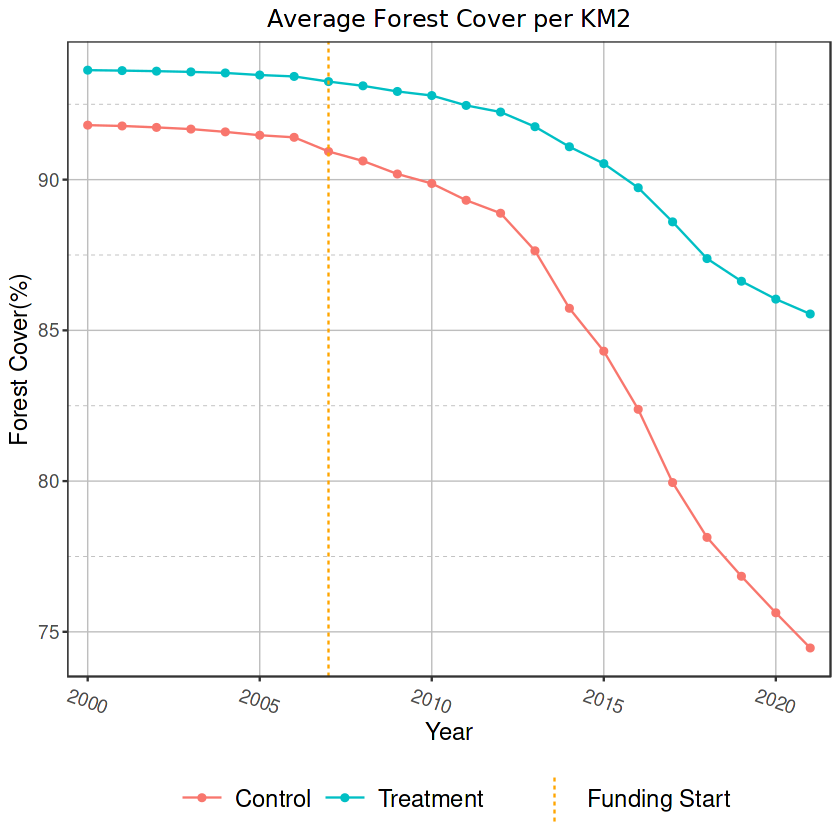

In [26]:
# Trend Plot
ggplot(df.matched.trend, aes(x = year, y = avgFC)) +
  geom_line(aes(group = group, color = as.character(group))) +
  geom_point(aes(color = as.character(group))) +
  geom_vline(aes(xintercept=as.character(funding.start), size="Funding Start"), linetype=2, linewidth=0.5, color="orange") +
  
  #scale_y_continuous(breaks=seq(0,100,10), labels=paste(seq(0,100,10)),
  #                   expand=c(0,0), limits=c(0,100)) +
  scale_x_discrete(breaks=seq(2000,2020,5), labels=paste(seq(2000,2020,5))) +
  scale_color_hue(labels = c("Control", "Treatment")) +
  
  labs(title = "Average Forest Cover per KM2",
       x = "Year", 
       y = "Forest Cover(%)", 
       color = "Group") +
  theme_bw() +
  theme(
    plot.title = element_text(family="Arial Black", size=14, hjust=0.5),
    
    axis.text.x = element_text(angle = -20, hjust = 0.5, vjust = 0.5),
    axis.text=element_text(size=11),
    axis.title=element_text(size=14),
    
    legend.position = "bottom",
    legend.title = element_blank(),
    legend.text=element_text(size=14),
    #legend.spacing.x = unit(1.0, 'cm'),
    legend.spacing.y = unit(0.75, 'cm'),
    legend.key.size = unit(2, 'line'),
    
    panel.grid.major.x = element_line(color = 'grey', linewidth = 0.3, linetype = 1),
    panel.grid.minor.x = element_line(color = 'grey', linewidth = 0.2, linetype = 2),
    panel.grid.major.y = element_line(color = 'grey', linewidth = 0.3, linetype = 1),
    panel.grid.minor.y = element_line(color = 'grey', linewidth = 0.2, linetype = 2),
    
  ) + guides(size = guide_legend(override.aes = list(color = "orange"))) # Add legend for geom_vline

In [27]:
# Difference of annual verage forest cover / 1-km2 between treated and control group
df.difFC = df.matched.trend %>%
    filter(matched==TRUE) %>%
    group_by(year) %>%
    summarise(difFC = diff(avgFC))
head(df.difFC)

year,difFC
<chr>,<dbl>
2000,1.824250
2001,1.836464
2002,1.865783
2003,1.897267
2004,1.954694
2005,1.997469


In [28]:
# Difference on average
df.difFC %>% filter(year>2006) %>% pull(difFC) %>% mean()

[1] 5.945474

Warning message:
“Using size for a discrete variable is not advised.”


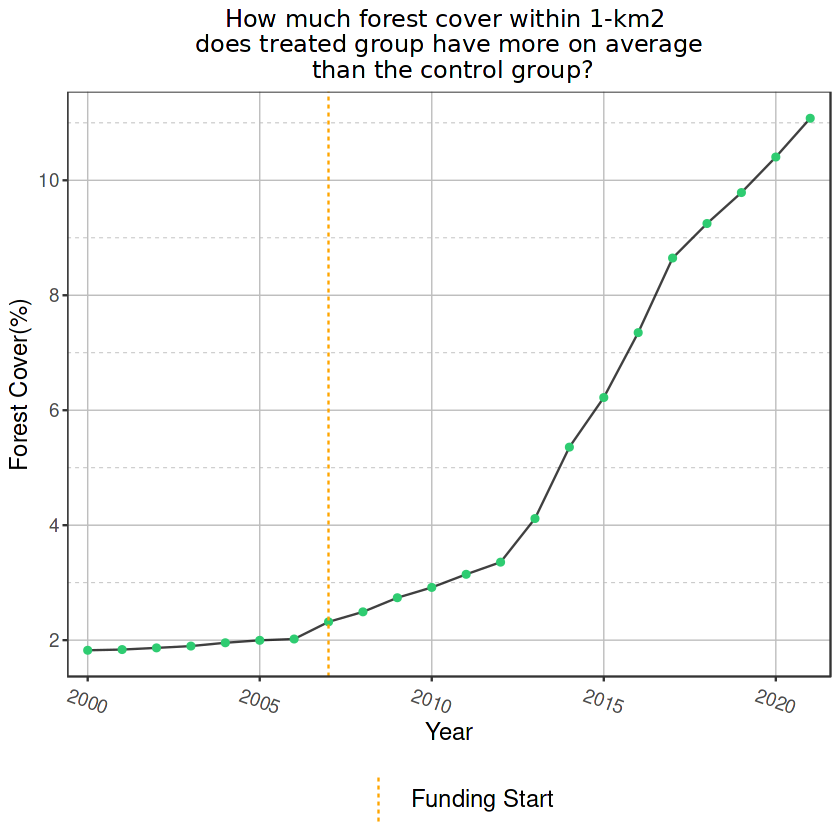

In [29]:
ggplot(df.difFC, aes(x = year, y = difFC, group=1)) +
  geom_line(alpha=0.75) +
  geom_point(color="#2ecc71") +
  geom_vline(aes(xintercept=as.character(funding.start), size="Funding Start"), linetype=2, linewidth=0.5, color="orange") +
  
  scale_y_continuous(breaks=seq(0,12,2), labels=paste(seq(0,12,2))) +
  scale_x_discrete(breaks=seq(2000,2020,5), labels=paste(seq(2000,2020,5))) +
  
  labs(title = "How much forest cover within 1-km2 \n does treated group have more on average \n than the control group?",
       x = "Year", 
       y = "Forest Cover(%)") +
  theme_bw() +
  theme(
    plot.title = element_text(family="Arial Black", size=14, hjust=0.5),
    
    axis.text.x = element_text(angle = -20, hjust = 0.5, vjust = 0.5),
    axis.text=element_text(size=11),
    axis.title=element_text(size=14),
    
    legend.position = "bottom",
    legend.title = element_blank(),
    legend.text=element_text(size=14),
    #legend.spacing.x = unit(1.0, 'cm'),
    legend.spacing.y = unit(0.75, 'cm'),
    legend.key.size = unit(2, 'line'),
    
    panel.grid.major.x = element_line(color = 'grey', linewidth = 0.3, linetype = 1),
    panel.grid.minor.x = element_line(color = 'grey', linewidth = 0.2, linetype = 2),
    panel.grid.major.y = element_line(color = 'grey', linewidth = 0.3, linetype = 1),
    panel.grid.minor.y = element_line(color = 'grey', linewidth = 0.2, linetype = 2),
    
  ) + guides(size = guide_legend(override.aes = list(color = "orange"))) # Add legend for geom_vline

## 5. Regression

In [30]:
feols(fc_pct ~ group | year,
      data = matched.long, 
      weights = matched.long$weights)

OLS estimation, Dep. Var.: fc_pct
Observations: 1,560,944 
Weights: matched.long$weights 
Fixed-effects: year: 22
Standard-errors: Clustered (year) 
      Estimate Std. Error t value   Pr(>|t|)    
group  3.46447   0.823761 4.20567 0.00039734 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 19.7     Adj. R2: 0.083764
             Within R2: 0.004285